# Processing the data

In [1]:
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from tensorflow import keras
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('CPU')
# print('CPUs Available: ' ,len(physical_devices))
print(physical_devices)
# file_path = '/Users/jackkelly/Desktop/Building_Model/Data/40_channels_data_4000.csv'
file_path = '/Users/jackkelly/Desktop/Building_Model/Data/30_channels_data_3000.csv'
N_channels = 30

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [3]:
def processing_data(N_channels, file_path):
    df = pd.read_csv(file_path)
    dataset = df.values
    # dataset
    dataset = df.values
    # input power and channels statuses
    X = dataset[:,0:N_channels+1]
    # channel SNRs
    Y = dataset[:,N_channels+1:2*N_channels+1]
    # shuffle necessary because while shuffle=True in .fit() shuffles the data, it splits into different datasets first
    X, Y = shuffle(X, Y)
    # scaling between 0 and 1
    min_max_scaler = preprocessing.MinMaxScaler()
    X_scale = min_max_scaler.fit_transform(X)
    Y_scale = min_max_scaler.fit_transform(Y)
    X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y_scale, test_size=0.3)
    X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)
    print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [4]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = processing_data(N_channels, file_path)

(2100, 31) (450, 31) (450, 31) (2100, 30) (450, 30) (450, 30)


# Building the ANN

In [5]:
model = Sequential()
model.add(Dense(80, activation='relu', input_dim=N_channels+1))
model.add(Dense(80, activation='relu'))
model.add(Dense(N_channels, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                2560      
_________________________________________________________________
dense_2 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                2430      
Total params: 11,470
Trainable params: 11,470
Non-trainable params: 0
_________________________________________________________________


In [6]:
# learning_rate=0.1 causes zig-zags, learning_rate=0.0001 is far too slow
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error'])

In [7]:
# fit as we are fitting the parameters to the data
# verbose shows how much info is shown during model fitting
# shuffle by default set to true so this is for visual purposes
hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=50, shuffle=True, verbose=1, batch_size=N_channels+1)

Train on 2100 samples, validate on 450 samples
Epoch 1/50
2100/2100 [==============================] - 1s 339us/step - loss: 0.1359 - mean_squared_error: 0.1359 - mean_absolute_error: 0.3391 - val_loss: 0.0933 - val_mean_squared_error: 0.0933 - val_mean_absolute_error: 0.2704
Epoch 2/50
2100/2100 [==============================] - 0s 81us/step - loss: 0.0750 - mean_squared_error: 0.0750 - mean_absolute_error: 0.2328 - val_loss: 0.0567 - val_mean_squared_error: 0.0567 - val_mean_absolute_error: 0.1975
Epoch 3/50
2100/2100 [==============================] - 0s 82us/step - loss: 0.0454 - mean_squared_error: 0.0454 - mean_absolute_error: 0.1756 - val_loss: 0.0344 - val_mean_squared_error: 0.0344 - val_mean_absolute_error: 0.1516
Epoch 4/50
2100/2100 [==============================] - 0s 89us/step - loss: 0.0273 - mean_squared_error: 0.0273 - mean_absolute_error: 0.1343 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1174
Epoch 5/50
2100/2100 [==============

2100/2100 [==============================] - 0s 78us/step - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0234 - val_loss: 9.4152e-04 - val_mean_squared_error: 9.4152e-04 - val_mean_absolute_error: 0.0214
Epoch 37/50
2100/2100 [==============================] - 0s 75us/step - loss: 8.9278e-04 - mean_squared_error: 8.9278e-04 - mean_absolute_error: 0.0222 - val_loss: 8.4184e-04 - val_mean_squared_error: 8.4184e-04 - val_mean_absolute_error: 0.0217
Epoch 38/50
2100/2100 [==============================] - 0s 75us/step - loss: 8.5610e-04 - mean_squared_error: 8.5610e-04 - mean_absolute_error: 0.0217 - val_loss: 8.6627e-04 - val_mean_squared_error: 8.6627e-04 - val_mean_absolute_error: 0.0207
Epoch 39/50
2100/2100 [==============================] - 0s 74us/step - loss: 8.7588e-04 - mean_squared_error: 8.7588e-04 - mean_absolute_error: 0.0220 - val_loss: 9.7067e-04 - val_mean_squared_error: 9.7067e-04 - val_mean_absolute_error: 0.0210
Epoch 40/50
2100/2100 [=============

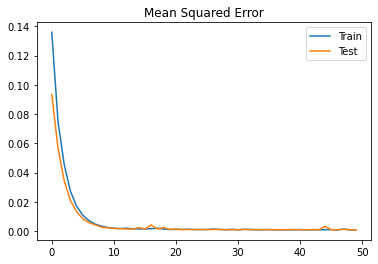

In [8]:
plt.title('Mean Squared Error')
plt.plot(hist.history['mean_squared_error'], label='Train')
plt.plot(hist.history['val_loss'], label='Test')
plt.legend()
plt.show()

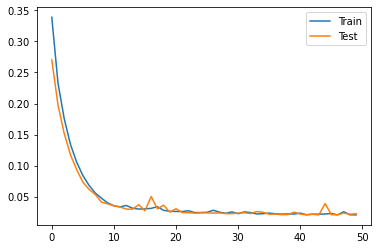

In [9]:
plt.plot(hist.history['mean_absolute_error'], label='Train')
plt.plot(hist.history['val_mean_absolute_error'], label='Test')
plt.legend()
plt.show()

In [10]:
#0 = loss, 1 = accuracy
train_mse = (model.evaluate(X_train, Y_train, verbose=1))[1]
test_mse = (model.evaluate(X_test, Y_test, verbose=1))[1]
val_mse = (model.evaluate(X_val, Y_val, verbose=1))[1]
print('MSE train: %.5f, MSE test: %.5f MSE val: %.5f' % (train_mse, test_mse, val_mse))

450/450 [==============================] - 0s 39us/step
MSE train: 0.00079, MSE test: 0.00089 MSE val: 0.00087


In [11]:
# MSE train: 0.00045, MSE test: 0.00047